# Model QC Notebook

<img style="float:right;" src="https://id.dewberry.com/clients/Templates/DewberryLogo_RGB.png" width=150px>

### Description
#### - What is needed to use this notebook
  1. adcirc library
  
#### - Steps to follow:
  1. Import Libraries & Assign Paths
  2. Assign Tasks
  3. Save Report

### 1. Import Libraries, Assign Paths, & Variables

In [1]:
%matplotlib inline

In [2]:
from ipywidgets import *
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt # Import the Matplotlib package
import numpy.core.multiarray 
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy.interpolate import griddata
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import matplotlib.tri as tri
from adcirc import adcirc
import os
import pandas as pd

/home1/04952/tmiesse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home1/04952/tmiesse/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home1/04952/tmiesse/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home1/04952/tmiesse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home1/04952/tmiesse/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home1/04952/tmiesse/anaconda3/lib/python3.6/site-packag

In [3]:
root_dir = r'/scratch/04952/tmiesse/Dewberry/QC'
f13, f14 = 'fort.13', 'fort.14'
fort13 = adcirc(root_dir,f13)
fort14 = adcirc(root_dir,f14)

### 2. Tasks

#### a. Find the attributes used in the Fort.13 file

In [4]:
attr = fort13.attributes()
attr

,Parameter
0,wave_refraction_in_swan
1,sea_surface_height_above_geoid
2,surface_directional_effective_roughness_length
3,surface_canopy_coefficient
4,mannings_n_at_sea_floor
5,primitive_weighting_in_continuity_equation
6,average_horizontal_eddy_viscosity_in_sea_water...


#### b. Read nodal attributes in fort.13 into a table

In [5]:
table13 = fort13.read_fort13(attr)
table13.head()


 Started finding nodes in attributes at 

2018-07-18 12:27:16.186753
===========END========== 

Processing Time : 
0:01:36.816057


,wave_refraction,sea_surface,surface_directional,surface_canopy,mannings_n,primitive_weighting,average_horizontal
0,1 0.000000,NaN,15490 0.0106490 0.00182500 0.00100000 0.001000...,16299 0.000000,24262 0.0500000,1 0.0200000,1 4.00000
1,2 0.000000,NaN,15491 0.00421200 0.00109300 0.00100000 0.00100...,21471 0.000000,25236 0.0500000,2 0.00500000,2 4.00000
2,3 0.000000,NaN,16297 0.0511780 0.0586370 0.131352 0.00131000 ...,25239 0.000000,25237 0.0370000,3 0.00500000,3 4.00000
3,4 0.000000,NaN,16298 0.0442180 0.0539520 0.0202930 0.0458700 ...,25245 2.27374e-013,25239 0.100000,4 0.00500000,4 4.00000
4,5 0.000000,NaN,16299 0.109154 0.143936 0.173318 0.123676 0.09...,25255 0.000000,25240 0.0370000,5 0.00500000,5 4.00000


#### c. Open and Read the nodes/locations in the fort14

In [6]:
table14 = fort14.read_fort14()
table14.head()

,node_id,node_x,node_y,value
0,1,-60.0400300000,8.5596800000,6.1570001000
1,2,-60.0402700000,8.6642500000,12.8529997000
2,3,-60.0405100000,8.7688200000,25.3540001000
3,4,-60.0409900000,8.9779600000,46.1559982000
4,5,-60.0414700000,9.1871000000,26.4549999000


#### d. Seperate the nodes and data in the fort.13 table 

In [7]:
table = pd.DataFrame.copy(table13)
table = adcirc.seperate_13(table)
table.head()

,sea_surface,wavenodes,wavedata,surfacedir_nodes,e,ese,se,s,sw,wsw,...,ne,ene,surfacenodes,surfacedata,manningsnodes,manningsdata,primitivenodes,primitivedata,averagenodes,averagedata
0,NaN,1,0.000000,15490,0.0106490,0.00182500,0.00100000,0.00100000,0.00100000,0.00100000,...,0.00104400,0.00242100,16299,0.000000,24262,0.0500000,1,0.0200000,1,4.00000
1,NaN,2,0.000000,15491,0.00421200,0.00109300,0.00100000,0.00100000,0.00100000,0.00100000,...,0.00100000,0.00397500,21471,0.000000,25236,0.0500000,2,0.00500000,2,4.00000
2,NaN,3,0.000000,16297,0.0511780,0.0586370,0.131352,0.00131000,0.00136100,0.00138400,...,0.124346,0.0652540,25239,0.000000,25237,0.0370000,3,0.00500000,3,4.00000
3,NaN,4,0.000000,16298,0.0442180,0.0539520,0.0202930,0.0458700,0.00156900,0.00142100,...,0.0808100,0.0702230,25245,2.27374e-013,25239,0.100000,4,0.00500000,4,4.00000
4,NaN,5,0.000000,16299,0.109154,0.143936,0.173318,0.123676,0.0925650,0.0855250,...,0.265285,0.159219,25255,0.000000,25240,0.0370000,5,0.00500000,5,4.00000


### e. Give nodal attribute locations and plot

wave = table[['wavenodes','wavedata']]
table_waves = table14.merge(wave, left_on='node_id',right_on='wavenodes')

In [23]:
manning = table[['manningsnodes','manningsdata']]
table_mann = table14.merge(manning, left_on='node_id',right_on='manningsnodes')

In [24]:
table_mann.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)
table_mann.head()

,node_id,lon,lat,value,manningsnodes,manningsdata
0,24262,-76.0400700000,36.8627850000,-4.0052042000,24262,0.0500000
1,25236,-75.9745860000,36.7831880000,-4.3569999000,25236,0.0500000
2,25237,-75.9781340000,36.8025210000,-4.3550000000,25237,0.0370000
3,25239,-76.0036090000,36.8302610000,-4.1448522000,25239,0.100000
4,25240,-76.0278930000,36.8323550000,-5.1129470000,25240,0.0370000


In [25]:
x= pd.to_numeric(table_mann['lon'])
y = pd.to_numeric(table_mann['lat'])

In [12]:
table_mann.head()

,node_id,lon,lat,value,manningsnodes,manningsdata
0,24262,-76.0400700000,36.8627850000,-4.0052042000,24262,0.0500000
1,25236,-75.9745860000,36.7831880000,-4.3569999000,25236,0.0500000
2,25237,-75.9781340000,36.8025210000,-4.3550000000,25237,0.0370000
3,25239,-76.0036090000,36.8302610000,-4.1448522000,25239,0.100000
4,25240,-76.0278930000,36.8323550000,-5.1129470000,25240,0.0370000


In [26]:
table_slice = table_mann[(x < -76.05) & (x > -78.25) 
                         & (y < 35.25) & (y > 34.059)]

In [28]:
table_slice.shape

(259170, 6)

In [27]:
table_slice.head()

,node_id,lon,lat,value,manningsnodes,manningsdata
7560,79672,-76.1205500000,35.0057800000,-1.5000000000,79672,0.0900000
7561,79673,-76.1188710000,35.0069350000,-1.5000000000,79673,0.0900000
7562,79674,-76.1172500000,35.0080500000,-1.5000000000,79674,0.0900000
7563,79675,-76.1156400000,35.0092400000,-1.5000000000,79675,0.0900000
7564,79676,-76.1139100000,35.0104400000,-1.5000000000,79676,0.0900000


In [92]:
table_slice.to_csv(r'/scratch/04952/tmiesse/Dewberry/QC/mannings.csv')

In [29]:
grid_x = table_slice['lon'].values
grid_y = table_slice['lat'].values
values = table_slice['manningsdata'].values

In [34]:
import xarray as xr

In [70]:
xtable = table_slice.to_xarray()

In [87]:
xtable.set_coords({xtable['index']:xtable['lon']})

TypeError: unhashable type: 'DataArray'

In [86]:
xtable.assign_coords(xtable['lon'])

TypeError: assign_coords() takes 1 positional argument but 2 were given

In [91]:
xx,yy = meshgrid(grid_x,grid_y)

NameError: name 'meshgrid' is not defined

ValueError: not enough values to unpack (expected 2, got 1)

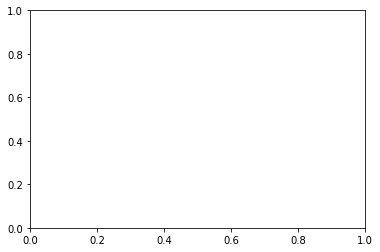

In [89]:
plt.pcolor(grid_x,grid_y,values)
plt.show()

In [53]:
#xtable.manningsdata.plot()
#xtable.manningsdata.plot(levels=4)

In [33]:
manningsplot = xtable.plot.pcolormesh('lon', 'lat', col='time', col_wrap=3, robust=True, cmap='viridis')


AttributeError: 'Dataset' object has no attribute 'plot'

In [ ]:
# Assign date of QC & Name/Info of QC Staff
qc_date = datetime.now()
qc_staff = 'Tyler Miesse'

print('QC Completed on {} by {}'.format(qc_date, qc_staff))

### Export Completed QC Report

## End